In [1]:
print("Hello Mr Data Scientist")

Hello Mr Data Scientist


# Best Practices
- Functions:
  - Single responsibility principle.
  - Use functions for cleaning & engineering, then use transformed data in model (no functions).

In [2]:
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.1


# Step 1. Frame the Problem

1. Define the objective in business terms.
2. How will your solution be used?
3. What are the current solutions/workarounds (if any)?
4. How should you frame this problem (supervised/unsupervised, online/offline,
etc.)?
5. How should performance be measured?
6. Is the performance measure aligned with the business objective?
7. What would be the minimum performance needed to reach the business objec‐
tive (MVP)?
8. What are comparable problems? Can you reuse experience or tools?
9. Is human expertise available?
10. How would you solve the problem manually?
11. List the assumptions you (or others) have made so far.
12. Verify assumptions if possible.

## Regression: Medical Insurance Cost Personal Dataset

https://www.kaggle.com/mirichoi0218/insurance

**Columns:**
- age: age of primary beneficiary
- sex: insurance contractor gender, female, male
- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- children: Number of children covered by health insurance / Number of dependents
- smoker: Smoking
- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- charges: Individual medical costs billed by health insurance

We want to predict insurance charges from other features.



# Step 2: Get the Data

**Note:** automate as much as possible so you can easily get fresh data.

1. List the data you need and how much you need.
2. Find and document where you can get that data.
3. Check how much space it will take.
4. Check legal obligations, and get authorization if necessary.
5. Get access authorizations.
6. Create a workspace (with enough storage space).
7. Get the data.
8. Convert the data to a format you can easily manipulate (without changing the
data itself).
9. Ensure sensitive information is deleted or protected (e.g., anonymized).
10. Check the size and type of data (time series, sample, geographical, etc.).
11. Sample a test set, put it aside, and never look at it (no data snooping!).

In [156]:
# Read the data
path = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
data = pd.read_csv(path)

In [6]:
# Inspect the data
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
data.shape

(1338, 7)

In [151]:
# Check for missing values
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [154]:
from sklearn.model_selection import train_test_split

def make_test_set(data, target_col, train_size=0.8, random_state=42):
    """Function takes pd DataFrame and target as a string, 
    create design matrix and target vector, and set aside a test sample.""" 
    # Copy the data
    X = data.copy()
    # Separate target from predictors
    y = X.pop(target_col)
    # Break off test data
    X, X_test, y, y_test = train_test_split(X, y,
                                            train_size=train_size,
                                            random_state=random_state)
    # Check shapes are correct
    assert X.shape[0] == y.shape[0] and X_test.shape[0] == y_test.shape[0] 
    # Return split data
    return X, X_test, y, y_test

In [157]:
X, X_test, y, y_test = make_test_set(data, 'charges')
X.shape

(1070, 6)

In [11]:
# Create train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)
X_train.shape

(856, 6)

# Step 3: Explore the Data

**Note:** try to get insights from a field expert for these steps.

1. Create a copy of the data for exploration (sampling it down to a manageable size
if necessary).
2. Create a Jupyter notebook to keep a record of your data exploration.
3. Study each attribute and its characteristics:
  - Name
  - Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
  - % of missing values
  - Noisiness and type of noise (stochastic, outliers, rounding errors, etc.)
  - Usefulness for the task
  - Type of distribution (Gaussian, uniform, logarithmic, etc.)
4. For supervised learning tasks, identify the target attribute(s).
5. Visualize the data.
6. Study the correlations between attributes.
7. Study how you would solve the problem manually.
8. Identify the promising transformations you may want to apply.
9. Identify extra data that would be useful (go back to “Get the Data”).
10. Document what you have learned.

https://www.kaggle.com/hely333/eda-regression

In [12]:
# Visualise


In [ ]:
# Correlations


In [ ]:
# Promising transformations


# Step 4: Prepare the Data

**Notes:**
- Work on copies of the data (keep the original dataset intact).
- Write functions for all data transformations you apply, for five reasons:
  - So you can easily prepare the data the next time you get a fresh dataset
  - So you can apply these transformations in future projects
  - To clean and prepare the test set
  - To clean and prepare new data instances once your solution is live
  - To make it easy to treat your preparation choices as hyperparameters

1. Data cleaning:
  - Fix or remove outliers (optional).
  - Fill in missing values (e.g., with zero, mean, median…) or drop their rows (or columns).
  - Parsing dates - `datetime`
2. Establish baseline model (pre- feature engineering)
3. Feature selection (optional):
  - Drop the attributes that provide no useful information for the task.
4. Feature engineering, where appropriate:
  - Discretize continuous features.
  - Decompose features (e.g., categorical, date/time, etc.).
  - Add promising transformations of features (e.g., $log(x), sqrt(x), x^2$, etc.).
  - **Kaggle:**
    - Mutual independence.
    - Aggregate new features.
    - $K$-means as a feature.
    - Principal components as features:
      - Or use 'loadings' to inform creation of new features.
    - Target encoding.
5. Feature scaling:
  - Standardize or normalize features.

## Establish Baseline Model

In [13]:
# Inspect data types
X.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
dtype: object

In [14]:
y.dtypes

dtype('float64')

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


def create_preprocessor(X=X, numerical_cols=None, categorical_cols=None): # X only needed for column names
    """Function creates simple preprocessing pipeline and create training and validation splits."""
    # Select numerical columns
    if numerical_cols is not None:
      numerical_cols = numerical_cols
    else:
      numerical_cols = [cname for cname in X.columns if
                        X[cname].dtype in ['int64', 'float64']]

    np.asarray(X[numerical_cols]).astype(np.float32)
    # Select categorical columns
    if categorical_cols is not None:
      categorical_cols = categorical_cols
    else:
      categorical_cols = [cname for cname in X.columns if
                          X[cname].dtype == "object"]
    # Preprocessing for numerical data
    numerical_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=2))                                 
    ])
    # Preprocessing for categorical data
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])
    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])   
    # Return preprocessor
    return preprocessor

In [16]:
# Example
create_preprocessor(X)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True)),
                                                 ('imputer',
                                                  KNNImputer(add_indicator=False,
                                                             copy=True,
                                                             metric='nan_euclidean',
                                                             missing_values=nan,
                                                             n_neighbors=2,
                                  

# Step 5: Shortlist Promising Models

**Notes:**
- If the data is huge, you may want to sample smaller training sets so you can train many different models in a reasonable time (be aware that this penalizes complex models such as large neural nets or Random Forests).
- Once again, try to automate these steps as much as possible.

1. Train many quick-and-dirty models from different categories (e.g., linear, naive Bayes, SVM, Random Forest, neural net, etc.) using standard parameters.
2. Measure and compare their performance.
  - For each model, use N-fold cross-validation and compute the mean and stan‐
dard deviation of the performance measure on the N folds.
3. Analyze the most important features for each algorithm.
4. Analyze the types of errors the models make.
  - What data would a human have used to avoid these errors?
5. Perform a quick round of feature selection and engineering.
6. Perform one or two more quick iterations of the five previous steps.
7. Shortlist the top three to five most promising models, preferring models that
make different types of errors.

In [17]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score

# Train model on scaled, encoded data
def train_model(X_train, y_train,
                model=XGBRegressor(), epochs=None, verbose=True,
                preprocessor=create_preprocessor(X_train)): # Argument only needed for column names               
    """Function applies `create_preprocessor()`,
    and gives R^2 on both training and validation data."""
    # Define preprocessor and model
    preprocessor = preprocessor
    model = model
    # Bundle preprocessing and modeling code in a pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    # Fit pipeline to train data with appropriate parameters if model is NN 
    if epochs is not None:
      return pipe.fit(X_train, y_train, model__epochs=epochs, model__verbose=verbose)
    else:
      return pipe.fit(X_train, y_train)


# Regression metric for fitted model
def model_r2(rgr,
             X_train, X_valid, y_train, y_valid): 
    # Get predictions
    pred_train = rgr.predict(X_train)
    pred_valid = rgr.predict(X_valid)
    # Print scores
    print()
    print('{}:'.format(rgr.named_steps['model'].__class__.__name__))
    print('Training R^2:', r2_score(y_train, pred_train))
    print('Validation R^2:', r2_score(y_valid, pred_valid))


# Classification metric for fitted model
def model_auc(clf,
              X_train, X_valid, y_train, y_valid):
    # Get predictions
    pred_train = clf.predict(X_train) # could edit to predict_proba and round at favoured cutoff
    pred_valid = clf.predict(X_valid)
    # Print scores
    print()
    print('{}:'.format(clf.named_steps['model'].__class__.__name__))
    print('Training R^2:', roc_auc_score(y_train, pred_train))
    print('Validation R^2:', roc_auc_score(y_valid, pred_valid))

In [18]:
# Baseline models
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

In [158]:
baseline_models = [XGBRegressor(), RandomForestRegressor(random_state=42), SVR(), LinearRegression(), ElasticNet(), KNeighborsRegressor(), GaussianProcessRegressor()]
for model in baseline_models:
    model_0 = train_model(X_train, y_train,
                          model)
    print(model_r2(model_0, X_train, X_valid, y_train, y_valid))

[14:14:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

XGBRegressor:
Training R^2: 0.9068181554749528
Validation R^2: 0.8202728041036307
None

RandomForestRegressor:
Training R^2: 0.9765815237996814
Validation R^2: 0.8137211849082056
None

SVR:
Training R^2: -0.090432671168315
Validation R^2: -0.11976985159702869
None

LinearRegression:
Training R^2: 0.7451883624468718
Validation R^2: 0.726802980650122
None

ElasticNet:
Training R^2: 0.49567602365960917
Validation R^2: 0.4837871280724474
None

KNeighborsRegressor:
Training R^2: 0.8297177504798698
Validation R^2: 0.7569796697438845
None

GaussianProcessRegressor:
Training R^2: 0.9989503911816148
Validation R^2: -3924.7001591144162
None


In [20]:
# Baseline neural network
preprocessor = create_preprocessor()
preprocessed_input = preprocessor.fit_transform(X_train)
[preprocessed_input.shape[1]]

[11]

In [21]:
# Define the model
nn_0 = keras.Sequential([
    layers.BatchNormalization(input_shape=[preprocessed_input.shape[1]]),
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(1)
])

# Compile model
nn_0.compile(
    loss=tf.keras.losses.mae,
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

In [22]:
# Fit model
nn_0_fitted = train_model(X_train, y_train,
                          model=nn_0, epochs=50, verbose=False)
model_r2(nn_0_fitted, X_train, X_valid, y_train, y_valid)


Sequential:
Training R^2: 0.8323853244989005
Validation R^2: 0.7933712924480198


## Shortlisted Models

- XGB Regressor
- Random Forest
- Neural Network

## Learning Curves

**Would more data help the model?** Let's see how train sizes affect error.Check if models:
- are underfitting/overfitting, and would benefit from strong feature engineering.
- have reducible train/validation error gaps, and would benefit from more data.

https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

**Plotting loss function metric:**
- Underfitting if:
  - *training* loss remains flat regardless of training.
  - *training* loss continues decreasing until end of training.
- Overfitting if:
  - *validation* loss begins to increase again, whilst *training* loss continues decreasing.
- Note:
  - if model is of **high bias** (not complex enough), it won't exploit information in new samples... too 'biased' toward pre-conceived notion of reality...so more data useful when model is of **high variance** (complex).

**Plotting performance metric:**
- Test error *reduces* as N increases, but training error **increases** as N increases. But they, generally, should not asymptotically intersect. If deviation between training and test error does not seem further reducible, more data may not be worthwhile! Perhaps better off doing something cheaper like feature generation etc.

Random Forest:

In [23]:
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

## Sklearn learning curves

def learning_curve_sklearn(X, y, model, scoring='r2'):
    """Scoring should be string. R^2 for regressors."""
    # X, X_test, y, y_test = make_test_set(data, 'charges')

    # Encode features
    preprocessor = create_preprocessor(X)
    Xt = preprocessor.fit_transform(X)
    # Create error scores
    train_sizes = [int(i) for i in np.linspace(10, 0.8*X.shape[0], 10).tolist()]
    train_sizes, train_scores, validation_scores = learning_curve(estimator=model,
                                                                  X=Xt, y=y,
                                                                  train_sizes=train_sizes,
                                                                  shuffle=True,
                                                                  cv=5,
                                                                  scoring=scoring)
    # Only need average of CV scores
    train_scores_mean = train_scores.mean(axis=1) # Across each row
    validation_scores_mean = validation_scores.mean(axis=1)
    # Plot learning curves
    plt.style.use('seaborn')
    plt.plot(train_sizes, 1-train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, 1-validation_scores_mean, label = 'Validation error')
    plt.ylabel('Error', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves for {}'.format(model.__class__.__name__), fontsize = 18, y = 1.03)
    plt.legend()
    plt.show()

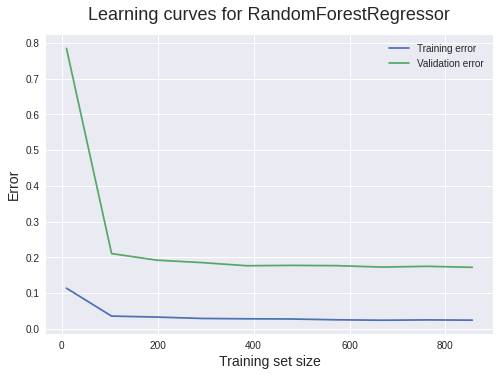

In [24]:
learning_curve_sklearn(X, y, RandomForestRegressor(random_state=42))

In [25]:
from sklearn.metrics import r2_score

## WQU learning curves

def learning_curve_batch(X_train, X_valid, y_train, y_valid,
                         model):
    # X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)

    # Encode features
    preprocessor = create_preprocessor(X)
    X_t = preprocessor.fit_transform(X_train)
    X_v = preprocessor.transform(X_valid)
    # Create lists of error scores
    error_train = []
    error_valid = []
    for n in range(50, X_train.shape[0], 50):
        X_batch = X_t[:n, :] # keep fitting model for increasing size of X and y (more observations) in batches of 50.
        y_batch = y_train[:n]
        
        model.fit(X_batch, y_batch)
        error_train.append(1-r2_score(model.predict(X_batch), y_batch)) # score close to 0 is good! (1-R^2)
        error_valid.append(1-r2_score(model.predict(X_v), y_valid)) # choose appropriate scoring metric
    # Plot learning curves
    plt.plot(error_train)
    plt.plot(error_valid)
    plt.ylabel('Error', fontsize = 14)
    plt.xlabel('Number of batches', fontsize = 14)
    plt.title('Learning curves for {}'.format(model.__class__.__name__), fontsize = 18, y = 1.03)
    plt.legend(['Training error', 'Validation error'])
    plt.show()

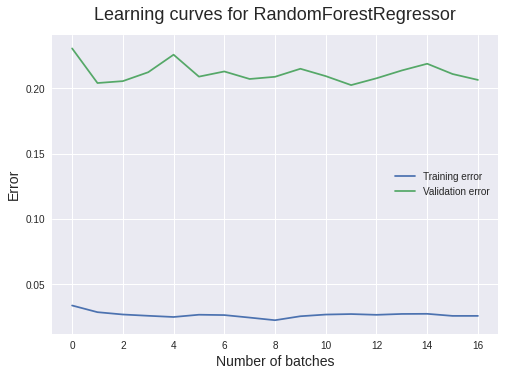

In [26]:
learning_curve_batch(X_train, X_valid, y_train, y_valid, model=RandomForestRegressor(random_state=42))

## In-depth Feature Engineering

Conduct feature engineering on just (X_train, y_train), but then create function that performs the chosen feature engineering on both training and validation data.

### Mutual Information

In [27]:
from sklearn.feature_selection import mutual_info_regression

In [28]:
X.dtypes == int

age          True
sex         False
bmi         False
children     True
smoker      False
region      False
dtype: bool

In [29]:
[pd.api.types.is_integer_dtype(t) for t in X.dtypes]

[True, False, False, True, False, False]

In [30]:
def make_mi_scores(X, y):
    X = X.copy()
    for cname in X.select_dtypes(["object", "category"]):
        X[cname], _ = X[cname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = X.dtypes == int
    # Generate MI scores
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=42)
    # Create Series indexed by feature names
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    # Order MI scores
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    # Labels are feature names
    ticks = list(scores.index)
    # Make plot
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

def drop_uninformative(X, mi_scores):
    return X.loc[:, mi_scores > 0.0]

In [31]:
scores = make_mi_scores(X_train, y_train)
scores

age         1.194240
smoker      0.366706
children    0.153740
sex         0.137331
bmi         0.123205
region      0.058991
Name: MI Scores, dtype: float64

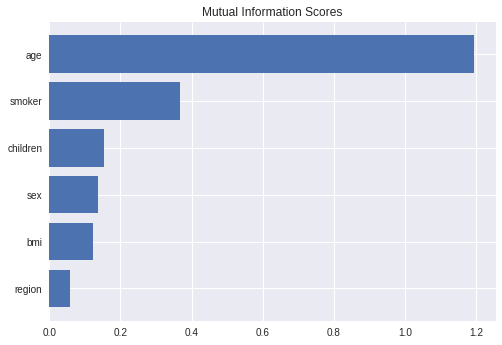

In [32]:
plot_mi_scores(scores)

In [33]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

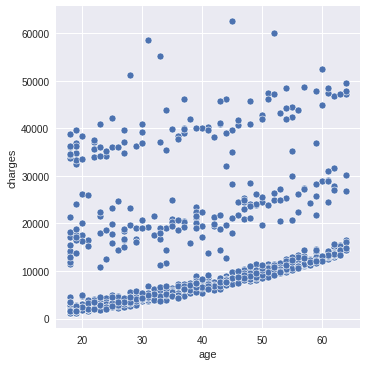

In [34]:
# Plot high-utility features against target

# sns.relplot(y='charges', x='age', data=data)
# Or:
sns.relplot(y=y_train, x=X_train.age)

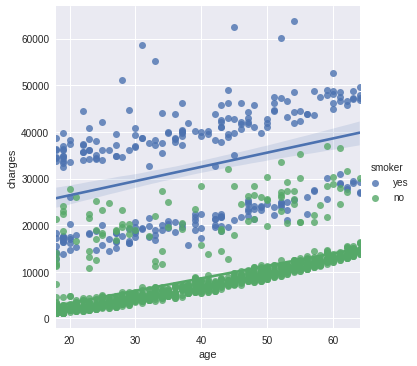

In [35]:
# sns.lmplot(y=y_train, x=X_train.age, hue=X_train.smoker, data=None)
sns.lmplot(y='charges', x='age', hue='smoker', data=data)

In [36]:
# Drop uninformative features to avoid overfitting
X_train_2 = drop_uninformative(X_train, mi_scores=scores)
X_valid_2 = drop_uninformative(X_valid, mi_scores=scores)

all = train_model(X_train, y_train)
informative = train_model(X_train_2, y_train)
print(model_r2(all, X_train, X_valid, y_train, y_valid))
print(model_r2(informative, X_train_2, X_valid_2, y_train, y_valid)) # Same

[11:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

XGBRegressor:
Training R^2: 0.9068181554749528
Validation R^2: 0.8202728041036307
None

XGBRegressor:
Training R^2: 0.9068181554749528
Validation R^2: 0.8202728041036307
None


In [37]:
# In this case, no features are dropped
X_train.equals(X_train_2) and X_valid.equals(X_valid_2)

True

### Creating Features

- Linear models learn sums and differences naturally, but can't learn anything more complex.
- Ratios seem to be difficult for most models to learn - easy performance gains.
- Linear models and neural nets generally do better with normalized features. Neural nets especially need features scaled to values not too far from 0. 
- Counts are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once.

### $K$-means Clustering

In [38]:
from sklearn.utils import shuffle
from sklearn.cluster import KMeans

def plot_inertia(X, preprocessor=create_preprocessor(),
                 n_clusters=range(1, 200, 2),
                 n_samples=None):
    # Need more observations than clusters
    assert n_samples >= len(n_clusters)
    # Need to scale and encode data to make kmeans work properly
    preprocessor = preprocessor
    # Shuffle before down-sampling for speed
    X_shuffled = shuffle(X, random_state=42)
    Xt = preprocessor.fit_transform(X_shuffled[:n_samples])
    # Create list of inertia scores
    inertia = []
    for n in n_clusters:
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(Xt)
        inertia.append(kmeans.inertia_)
    # plot relative inertia
    plt.plot(n_clusters, inertia/inertia[0])
    plt.hlines(0.1, n_clusters[0], n_clusters[-1], 'r', linestyles='dashed')
    plt.hlines(0.05, n_clusters[0], n_clusters[-1], 'r', linestyles='dashed')
    plt.xlabel('clusters')
    plt.ylabel('relative inertia')
    plt.legend(['inertia', '10% relative inertia', '5% relative inertia']);

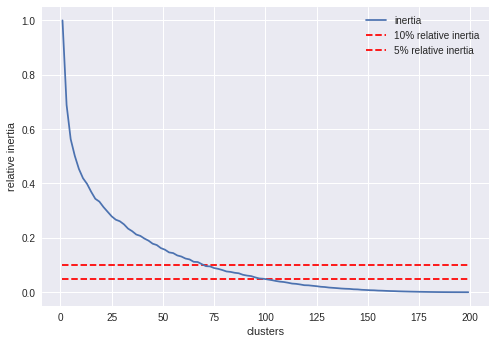

In [39]:
plot_inertia(X_train, n_samples=200)

In [40]:
# Creating new features with clustering

def cluster_labels(X, cluster_features, n_clusters=20):
    X = X.copy()
    X = X.loc[:, cluster_features]
    X_scaled = preprocessor.fit_transform(X)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=42)
    # Create new dataframe for joining
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(X, cluster_features, n_clusters=20):
    X = X.copy()
    X = X.loc[:, cluster_features]
    X_scaled = preprocessor.fit_transform(X)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=42)   
    # Label features and add to dataset for joining
    X_cd = kmeans.fit_transform(X_scaled)
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

In [41]:
# Cluster labels with 80 clusters
cluster_labels(X_train, cluster_features=X_train.columns, n_clusters=80)

,Cluster
0,43
1,14
2,27
3,30
4,70
...,...
851,50
852,42
853,44
854,37


In [42]:
# Cluster distance with 80 clusters
cluster_distance(X_train, cluster_features=X_train.columns, n_clusters=80).head()

,Centroid_0,Centroid_1,Centroid_2,Centroid_3,Centroid_4,Centroid_5,Centroid_6,Centroid_7,Centroid_8,Centroid_9,Centroid_10,Centroid_11,Centroid_12,Centroid_13,Centroid_14,Centroid_15,Centroid_16,Centroid_17,Centroid_18,Centroid_19,Centroid_20,Centroid_21,Centroid_22,Centroid_23,Centroid_24,Centroid_25,Centroid_26,Centroid_27,Centroid_28,Centroid_29,Centroid_30,Centroid_31,Centroid_32,Centroid_33,Centroid_34,Centroid_35,Centroid_36,Centroid_37,Centroid_38,Centroid_39,Centroid_40,Centroid_41,Centroid_42,Centroid_43,Centroid_44,Centroid_45,Centroid_46,Centroid_47,Centroid_48,Centroid_49,Centroid_50,Centroid_51,Centroid_52,Centroid_53,Centroid_54,Centroid_55,Centroid_56,Centroid_57,Centroid_58,Centroid_59,Centroid_60,Centroid_61,Centroid_62,Centroid_63,Centroid_64,Centroid_65,Centroid_66,Centroid_67,Centroid_68,Centroid_69,Centroid_70,Centroid_71,Centroid_72,Centroid_73,Centroid_74,Centroid_75,Centroid_76,Centroid_77,Centroid_78,Centroid_79
0,4.253805,2.506089,3.190134,3.786707,3.409899,4.111271,2.706412,1.665818,2.892848,3.711522,2.539257,3.953561,2.776630,2.887715,2.720857,3.109147,2.229219,3.487202,4.106898,2.240824,2.999730,2.669217,3.941576,2.902080,3.066300,2.761288,2.225415,2.688871,3.403150,3.317771,3.198138,4.129451,3.670732,2.385069,4.048833,3.184654,2.025909,4.458864,3.456796,2.744800,2.881916,2.291071,3.311396,0.682033,2.714680,2.696882,4.171151,2.275043,2.443020,3.332837,1.947202,3.737363,3.419861,3.763647,3.664662,2.959390,3.993189,3.800070,2.576798,2.863435,3.299728,2.840393,3.899261,3.697470,3.090919,2.553419,2.999180,2.894760,2.113207,3.573221,3.651966,2.605147,3.755634,2.612414,3.296250,2.426410,5.297658,3.131211,3.341262,2.553929
1,2.629950,2.776218,1.480212,3.374443,1.950185,2.568948,2.513086,2.370258,2.365245,1.369797,3.221041,2.330678,2.243522,2.313761,0.990555,1.703382,2.947602,2.693511,2.366895,3.035211,1.765023,3.077228,2.878473,2.717527,2.063635,2.828267,2.763626,2.534924,2.963657,2.270967,2.097843,1.787679,2.579691,1.870430,2.368459,3.135786,2.438957,3.264843,3.378089,1.637054,1.924677,2.396926,2.441648,2.949449,2.191229,1.925764,3.029424,2.810520,2.417555,2.308306,2.345959,2.940794,2.908275,1.717479,1.918520,2.851140,2.466883,2.222262,2.362996,2.303453,2.382257,3.184746,2.701916,2.601058,2.806442,1.509787,2.503323,2.096404,2.046572,2.939615,2.486642,2.546740,1.951300,2.320445,2.169887,2.851778,3.264707,2.438597,3.354907,2.368145
2,3.177917,1.521986,3.253980,4.028271,3.649758,3.790662,2.029861,2.651731,3.720923,2.510857,2.110460,2.776100,2.701407,2.165192,2.573595,3.692258,3.876009,3.558718,3.536738,2.360816,3.856018,2.415811,3.345929,3.611386,2.449483,2.778327,3.052480,0.394401,3.698489,1.607282,3.260844,3.120719,2.899213,2.536817,4.449204,3.448809,2.662567,4.461573,4.576347,2.269248,1.896141,3.294237,4.544885,2.517001,3.023680,3.035700,4.317196,1.887844,3.889468,3.403710,2.988144,3.386273,3.452085,3.074385,3.247929,3.009270,4.666646,3.466270,2.797451,2.217021,3.950800,3.502907,3.815342,4.700230,3.939992,2.824388,2.969659,3.595408,2.623330,3.584345,2.126490,2.233424,3.187747,3.023115,3.050361,1.494579,3.866930,3.702313,4.818678,3.630338
3,2.871680,2.369082,1.441600,2.872616,1.884891,2.845211,2.887452,1.707257,2.743158,2.572966,2.256742,2.514354,2.500104,2.640214,2.186088,2.143672,2.526731,3.097128,2.385253,2.437227,2.185736,2.459397,2.498960,1.410450,1.908150,2.542266,1.673708,2.557006,3.126889,3.125590,0.725907,2.770698,2.211702,2.757179,2.591675,2.775924,1.416103,3.042555,2.860904,1.780851,2.630929,2.491876,2.558371,2.435529,1.739316,1.866441,3.185399,2.793518,2.295226,2.038467,2.626920,1.997946,2.296667,2.855400,2.946466,2.900130,2.972905,2.687242,1.730511,2.203804,2.789945,2.622578,3.119778,2.950639,2.123079,2.049225,2.532810,2.537073,1.790819,2.422063,2.749822,1.313956,2.659492,2.630444,1.702105,2.490146,4.200669,2.521120,2.713644,1.819102
4,1.849641,2.779417,2.814051,3.717381,2.426377,3.329414,3.133301,3.151564,3.815302,1.603155,3.685498,1.226955,3.300610,3.201941,2.795249,3.227336,4.139231,2.9801

### PCA

- PCA only works with numeric features, like continuous quantities or counts.
- PCA is sensitive to scale. It's good practice to standardize your data before applying PCA, unless you know you have good reason not to.
- Consider removing or constraining outliers, since they can an have an undue influence on the results.

In [43]:
from sklearn.decomposition import PCA

def apply_pca(X, pca_features=None, standardize=True):
    # Keep only numerical features
    X = X.loc[:, pca_features] 
    # Standardize
    if standardize:
        scaler = create_preprocessor(X)
        X_scaled = scaler.fit_transform(X)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [44]:
# PCA loadings to inform feature creation
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
loadings = apply_pca(X_train, pca_features=numerical_cols)[2]
loadings

,PC1,PC2,PC3
age,0.727309,0.093702,-0.679883
bmi,0.636288,-0.463329,0.616817
children,0.257213,0.881218,0.396605


In [45]:
# PCA components as features
X_train_pca = apply_pca(X_train, pca_features=numerical_cols)[1]
X_train_pca

,PC1,PC2,PC3
0,1.534243,0.739325,-0.823707
1,0.418216,0.317403,0.837548
2,1.611435,-1.229510,-0.596294
3,0.312303,0.526803,0.440969
4,0.441708,-1.052847,1.818332
...,...,...,...
851,0.391203,0.689812,0.027610
852,0.489696,2.133887,0.852226
853,2.158644,1.315432,1.588382
854,-2.188632,-0.270182,-0.263348


In [46]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f780d158c50>,
      dtype=object)

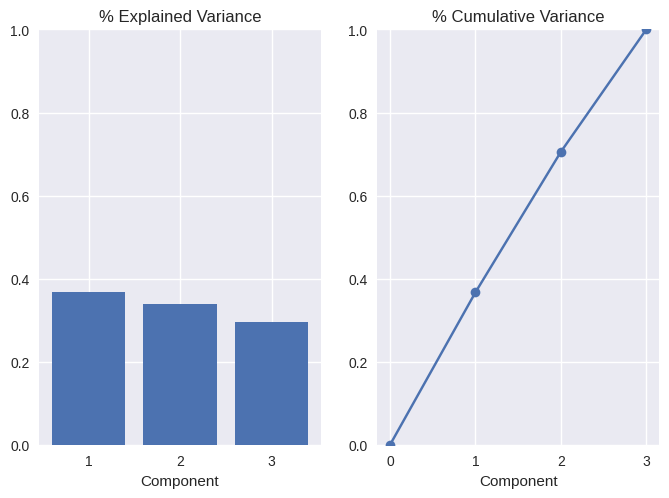

In [47]:
# Plot explained variance
pca = apply_pca(X_train, pca_features=numerical_cols)[0]
plot_variance(pca) # keep all

In [48]:
mi_scores_pca = make_mi_scores(X_train_pca, y_train)
mi_scores_pca # keep all

PC1    0.536942
PC3    0.225507
PC2    0.139015
Name: MI Scores, dtype: float64

### Target Encoding

Needing a separate holdout set to create a target encoding is a rather wasteful use of data.

There is, however, a way you can use target encoding without having to use held-out encoding data, and still mitigating overfitting. It's basically the same trick used in cross-validation:

1. Split the data into folds, each fold having two splits of the dataset.
2. Train the encoder on one split but transform the values of the other.
3. Repeat for all the splits.

This way, training and transformation always take place on independent sets of data, just like when you use a holdout set but without any data going to waste.

In the next cell is a wrapper you can use with any target encoder:

In [49]:
from sklearn.model_selection import KFold

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5, random_state=42)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

You can turn any of the encoders from the `category_encoders` library into a cross-fold encoder. The `CatBoostEncoder` would be worth trying. It's similar to `MEstimateEncoder` but uses some tricks to better prevent overfitting. Its smoothing parameter is called `a` instead of `m`.

In [50]:
pip install category_encoders

     |████████████████████████████████| 81kB 3.6MB/s 


In [51]:
import category_encoders as ce

from category_encoders import MEstimateEncoder
from category_encoders import CatBoostEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [52]:
X_train.head()

,age,sex,bmi,children,smoker,region
94,64,female,31.30,2,yes,southwest
814,36,male,34.43,2,no,southeast
246,60,female,38.06,0,no,southeast
794,39,female,31.92,2,no,northwest
1239,25,female,42.13,1,no,southeast


In [53]:
encoder = CrossFoldEncoder(MEstimateEncoder, m=1) # Larger m puts more weight on overall estimate --> less overfitting

# Target encode region
X_encoded = encoder.fit_transform(X_train, y_train, cols=['region'])
X_encoded.head()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,region_encoded
94,12519.074394
814,14094.413639
246,14094.413639
794,11264.924036
1239,14094.413639


### Putting It All Together

The `create_features()` function is used to feature engineer data in one go, using exploration above. Using just training data, try different permutations (comment out) to see best combination of feature engineering. Once we are happy feature engineering (and hyperparam tuning), come back and supply test data argument - we should conduct entire process on all the data we have (Train + Validation). Then check against test set (NO MORE TUNING).



In [54]:
def create_features(X_train, y_train, X_test=None,
                    numerical_cols=None,
                    categorical_cols=['region']):
    X = X_train.copy()
    y = y_train.copy()
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if X_test is not None:
        X_test = X_test.copy()
        X = pd.concat([X, X_test])

    # Lesson 2 - Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Lesson 3 - Transformations
    # X = X.join(mathematical_transforms(X))
    # X = X.join(interactions(X))
    # X = X.join(counts(X))
    # X = X.join(break_down(X))
    # X = X.join(group_transforms(X))

    # Lesson 4 - Clustering
    X = X.join(cluster_labels(X, cluster_features=X.columns, n_clusters=80).set_index(X.index))
    # X = X.join(cluster_distance(X, cluster_features=X.columns, n_clusters=80).set_index(X.index))

    # Lesson 5 - PCA
    # X = X.join(pca_inspired(X))
    X = X.join(apply_pca(X, pca_features=numerical_cols)[1].set_index(X.index))
    # X = X.join(indicate_outliers(X))

    # Reform splits
    if X_test is not None:
        X_test = X.loc[X_test.index, :]
        X.drop(X_test.index, inplace=True)

    # Lesson 6 - Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=categorical_cols))

    if X_test is not None:
        X_test = X_test.join(encoder.transform(X_test)) # Avoid overfitting by only target encoding on non-validation data

    # Return modified data
    if X_test is not None:
        return X, X_test
    else:
        return X

In [55]:
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]
categorical_cols

['sex', 'smoker', 'region']

In [56]:
X_train_3, X_valid_3 = create_features(X_train=X_train, y_train=y_train, X_test=X_valid,
                            numerical_cols=numerical_cols,
                            categorical_cols=['region'])

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [57]:
X_train_3.head()

,age,sex,bmi,children,smoker,region,Cluster,PC1,PC2,PC3,region_encoded
94,64,female,31.30,2,yes,southwest,69,-1.550783,0.635217,-0.902526,12519.074394
814,36,male,34.43,2,no,southeast,63,-0.459842,0.354293,0.818286,14094.413639
246,60,female,38.06,0,no,southeast,46,-1.548765,-1.345841,-0.561340,14094.413639
794,39,female,31.92,2,no,northwest,25,-0.349570,0.549152,0.408396,11264.924036
1239,25,female,42.13,1,no,southeast,26,-0.454339,-0.977610,1.885663,14094.413639


In [58]:
X_train.head()

,age,sex,bmi,children,smoker,region
94,64,female,31.30,2,yes,southwest
814,36,male,34.43,2,no,southeast
246,60,female,38.06,0,no,southeast
794,39,female,31.92,2,no,northwest
1239,25,female,42.13,1,no,southeast


In [59]:
pre = train_model(X_train, y_train)
print(model_r2(pre, X_train, X_valid, y_train, y_valid))

engineered = train_model(X_train_3, y_train)
print(model_r2(engineered, X_train_3, X_valid_3, y_train, y_valid)) # The same... see if true for LV= dataset...

[11:06:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

XGBRegressor:
Training R^2: 0.9068181554749528
Validation R^2: 0.8202728041036307
None
[11:06:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

XGBRegressor:
Training R^2: 0.9068181554749528
Validation R^2: 0.8202728041036307
None


# Step 6: Fine-Tune the System

**Notes:**
- You will want to use as much data as possible for this step, especially as you move toward the end of fine-tuning.
- As always, automate what you can.

1. Fine-tune the hyperparameters using cross-validation:
  - Treat your data transformation choices as hyperparameters, especially when
you are not sure about them (e.g., if you’re not sure whether to replace missing
values with zeros or with the median value, or to just drop the rows).
  - Unless there are very few hyperparameter values to explore, prefer random
search over grid search. If training is very long, you may prefer a Bayesian
optimization approach *(e.g., using Gaussian process priors, as described by
Jasper Snoek et al.)*
2. Try Ensemble methods. Combining your best models will often produce better
performance than running them individually.
3. Once you are confident about your final model, measure its performance on the
test set to estimate the generalization error.

## Grid Search

In [60]:
from sklearn.model_selection import RandomizedSearchCV

### XGB Regressor

In [61]:
# Baseline model with engineered features
xgb_0 = train_model(X_train_3, y_train)
model_r2(xgb_0, X_train_3, X_valid_3, y_train, y_valid)

[11:06:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

XGBRegressor:
Training R^2: 0.9068181554749528
Validation R^2: 0.8202728041036307


In [62]:
# Grid search / Optuna (define objective)

In [63]:
# Tuned model

### Random Forest

In [64]:
# Baseline model with engineered features
rf_0 = train_model(X_train_3, y_train,
                   model=RandomForestRegressor(random_state=42))
model_r2(rf_0, X_train_3, X_valid_3, y_train, y_valid)


RandomForestRegressor:
Training R^2: 0.9765815237996814
Validation R^2: 0.8137211849082056


In [65]:
# Grid search
rf_1 = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ])

rf_grid = {'model__max_depth': np.linspace(1, 1000, 4),
           'model__min_samples_split': np.logspace(-3, 1, 4)}

rf_search = RandomizedSearchCV(rf_1, rf_grid, scoring='r2', cv=5, random_state=42,
                               n_jobs=-1, verbose=1, n_iter=100)

rf_search.fit(X_train_3, y_train)
rf_search.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 16 is smaller than n_iter=100. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   14.5s finished


{'model__max_depth': 334.0, 'model__min_samples_split': 0.021544346900318832}

In [66]:
# Tuned model
rf_tuned = rf_search.best_estimator_
model_r2(rf_tuned, X_train_3, X_valid_3, y_train, y_valid) # improvement!


RandomForestRegressor:
Training R^2: 0.9101297936090916
Validation R^2: 0.8238186115613804


### Neural Network

In [67]:
# Reproduce baseline model with engineered features
nn_0 = keras.Sequential([
    layers.BatchNormalization(input_shape=[preprocessed_input.shape[1]]),
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(1)
])

nn_0.compile(
    loss=tf.keras.losses.mae,
    optimizer=tf.keras.optimizers.Adam(lr=0.01),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

nn_0_fitted = train_model(X_train, y_train,
                          model=nn_0, epochs=50, verbose=False)
model_r2(nn_0_fitted, X_train, X_valid, y_train, y_valid)


Sequential:
Training R^2: 0.7693463274424718
Validation R^2: 0.7336495412143826


In [68]:
# Grid search / Keras tuner

In [69]:
# Tuned model

## Custom Ensemble

Need to convert our individual estimators from predictors to transformers. Then apply simultaneous transforms via `FeatureUnion()`. Then combine as inputs for final predictor via `Pipeline()`.

https://github.com/danielarifmurphy/wqu_unit_2/blob/main/machine_learning/ML_FeatureEngineering-Copy1.ipynb

https://stats.stackexchange.com/questions/139042/ensemble-of-different-kinds-of-regressors-using-scikit-learn-or-any-other-pytho

## Test Set Performance

**NO MORE TUNING.**

In [70]:
# Create features in the same way
X_3, X_test_3 = create_features(X, y, X_test,
                                numerical_cols=numerical_cols, categorical_cols=['region'])

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


XGB:

Random Forest:

In [71]:
# Dictionary of best parameters from grid search
rf_best_params = {p.replace("model__", ""): v for p, v in rf_search.best_params_.items()}

# Test set performance
rf_test = train_model(X_3, y,
                      model=RandomForestRegressor(**rf_best_params, random_state=42))
model_r2(rf_test, X_3, X_test_3, y, y_test) # nice!


RandomForestRegressor:
Training R^2: 0.8982025095070038
Validation R^2: 0.8717771085067642


Neural Network:

## Persisting Best Model

**NO MORE TUNING.**

For a non- Keras model:

In [139]:
import dill

# Save/dump model to disk
with open('rf_test.dill', 'wb') as f:  # .dill is just convention to remind, but could name as anything; f is file handle
    dill.dump(rf_test, f)              # (model, handle)

In [140]:
# Read saved model
with open('rf_test.dill', 'rb') as f:  # rb = read binary
    rf_test_load = dill.load(f)

In [143]:
rf_test_load.predict(X_test_3[:10]) # Already fit. Can predict straight away on new data!

array([ 9971.69607305,  5229.65660173, 26720.23922696, 10138.34393417,
       35437.740917  ,  7493.15418272,  2013.07959913, 14566.12256871,
        7869.96235589, 11219.79825451])

In [144]:
r2_score(rf_test_load.predict(X_test_3), y_test) # And score!

0.860368872929592

For a Keras model:

`model = ...  # Get model (Sequential, Functional Model, or Model subclass)`
`model.save('path/to/location')`

Loading the model back:

`model = keras.models.load_model('path/to/location')`

# Step 7: Interpretable ML / Explainable AI

In future, conduct this before final model deployment (on Train+Val vs Test).

**Kaggle:**
1. General model:
  - Default feature importance
  - Permutation importance
  - Partial dependance plots
2. Specific instance:
  - SHAP values
  - Aggregate SHAP
  - LIME
  - breakDown

## General Model

### Feature Importances

In [103]:
# Default feature importance
def make_feature_importance_plot(fitted_model):
    sorted_idx = fitted_model.named_steps['model'].feature_importances_.argsort()
    feature_importances = pd.Series(data=fitted_model.named_steps['model'].feature_importances_,
                                    index=X_3.columns[sorted_idx]).sort_values(ascending=False)
    plot = feature_importances.plot.bar()
    return plot

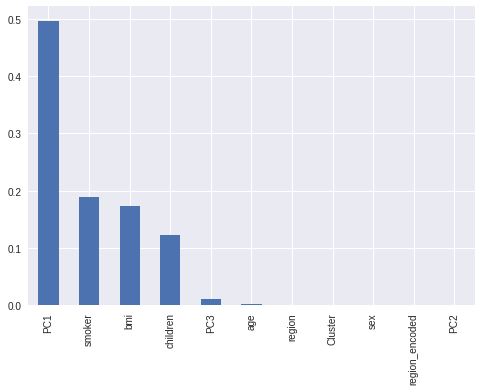

In [106]:
make_feature_importance_plot(rf_test_load)

Text(0, 0.5, 'charges')

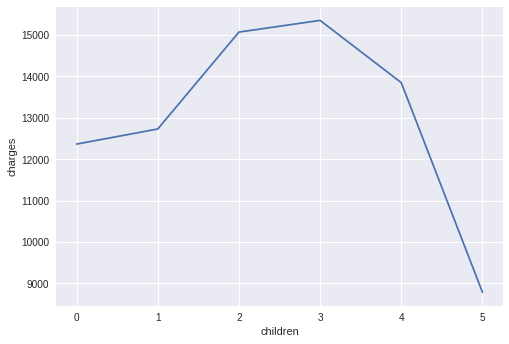

In [94]:
# Investigate
data.groupby('children').mean()['charges'].plot() # trend?
plt.ylabel('charges')

Triple plots for each feature in "A.2 Descriptive analysis" could be useful:

https://poseidon01.ssrn.com/delivery.php?ID=178085004002124023015069121110000024060082067020068050097083089005006088095007118071031096111043054039035085100001067115025091022055033035034022115008107077005029027075032022123102070116027072003124123069017000031069085117086110093064003070116071001&EXT=pdf&INDEX=TRUE

### Permutation Importances

Typically calculated with respect to validation set. We will just re-use the final training set, BEFORE one-hot-encoding.

In [80]:
pip install eli5

     |████████████████████████████████| 112kB 6.0MB/s 


In [81]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [107]:
def make_permutation_importance_plot(fitted_model, X_test, y_test):
    # Permuted predictions computed with respect to hold-out set
    result = permutation_importance(fitted_model, X_test, y_test, random_state=42)
    permutation_importances = pd.Series(data=result.importances_mean,
                                        index=X_3.columns).sort_values(ascending=False)
    plot = permutation_importances.plot.bar()
    return plot

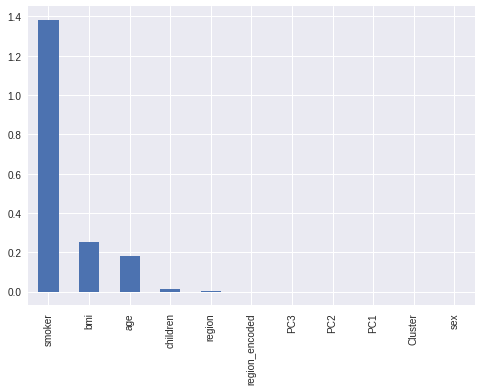

In [109]:
make_permutation_importance_plot(rf_test_load, X_test_3, y_test)

In [110]:
def make_permutation_importance_boxplot(fitted_model, X_test, y_test):
    result = permutation_importance(fitted_model, X_test, y_test, random_state=42)
    sorted_idx = result.importances_mean.argsort()
    # Make plot
    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T,
              vert=False, labels=X_final_3.columns[sorted_idx])
    ax.set_title("Permutation Importances")
    fig.tight_layout()
    plt.show()

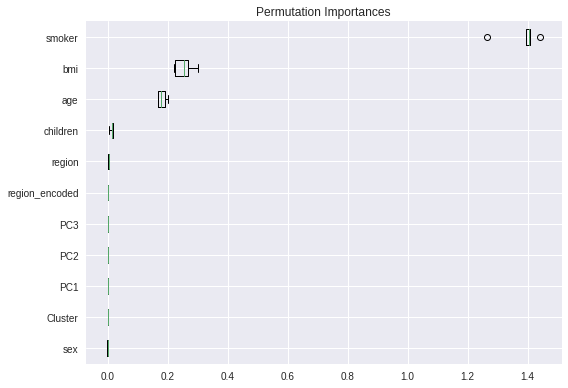

In [111]:
make_permutation_importance_boxplot(rf_test_load, X_test_3, y_test)

### Partial Dependence Plots

Only works for numerical features.

In [84]:
pip install pdpbox

     |████████████████████████████████| 34.0MB 116kB/s 
     |████████████████████████████████| 13.1MB 342kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-cp37-none-any.whl size=35758228 sha256=7a00726644ba07bcdc014b2db88312392d700707a464f931a8e8c48d73eae77a
  Stored in directory: /root/.cache/pip/wheels/c8/13/11/ecac74c6192790c94f6f5d919f1a388f927b9febb690e45eef
Successfully built pdpbox
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [85]:
from pdpbox import pdp, get_dataset, info_plots

In [113]:
def make_partial_dependence_plot(fitted_model, X_test, feature):
    # Create the data that we will plot
    pdp_bmi = pdp.pdp_isolate(model=fitted_model, dataset=X_test, model_features=X_test.columns, feature=feature)
    # Make plot
    pdp.pdp_plot(pdp_bmi, '{}'.format(feature))
    plt.show()
    print()

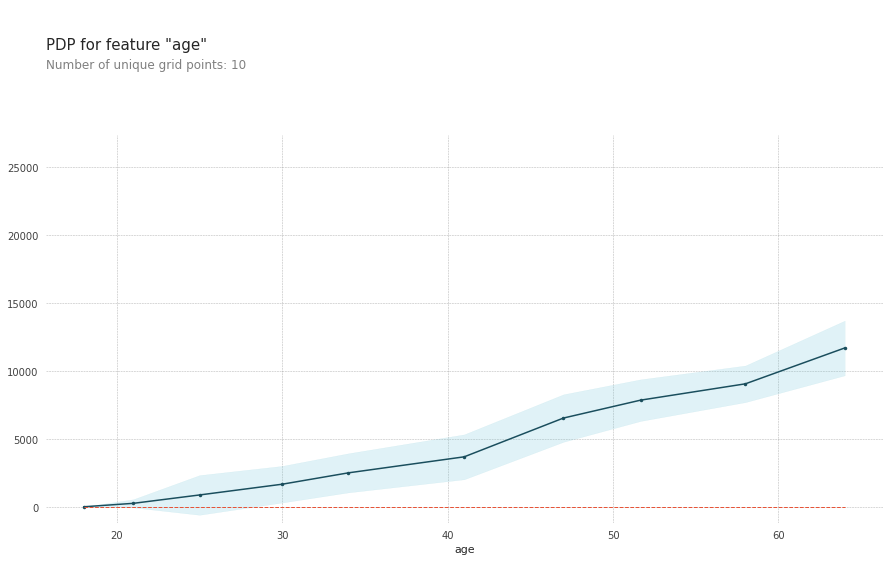

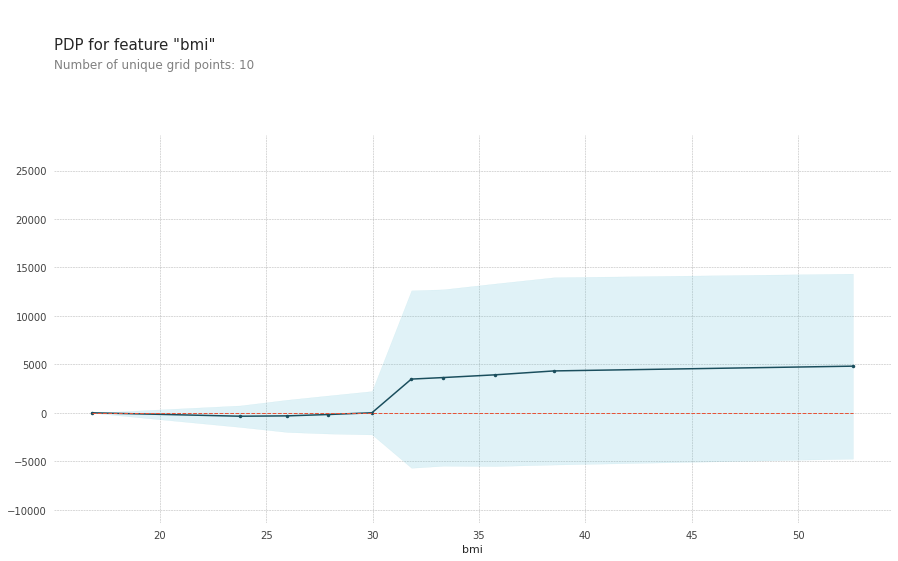

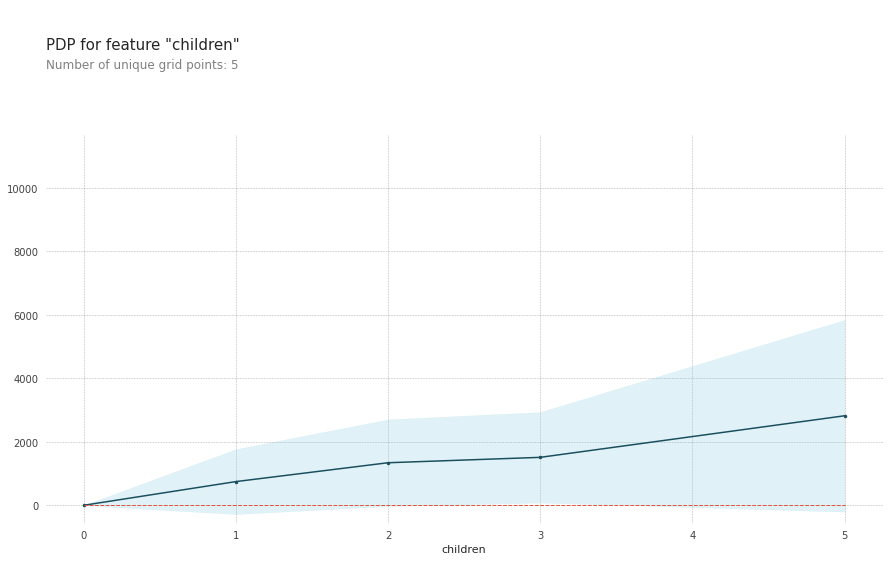

In [114]:
for feature in numerical_cols:
    make_partial_dependence_plot(rf_test_load, X_test_3, feature)

### SHAP Values

In [87]:
pip install shap

     |████████████████████████████████| 358kB 6.7MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491632 sha256=2fb5a08d82412915a61536e0de9c6ac90e7b07cd3ee5f963a5fc151500ae3f18
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


**SHAP Force Plots:**
- Example breakdown for a single row.

In [119]:
import shap

# Need to turn array to df with column names first
def model_predict(data_asarray):
    data_asframe =  pd.DataFrame(data_asarray, columns=X_test_3.columns)
    return rf_test_load.predict(data_asframe) # Change to fitted model in question


def make_force_plot(model, data_for_prediction):
    # Create explainer object that can calculate shap values
    explainer = shap.KernelExplainer(model_predict, data=X_test_3)
    shap_values = explainer.shap_values(data_for_prediction)
    # Plot breakdown for this observation
    shap.initjs()
    plot = shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)
    print(explainer.expected_value) # Prediction from baseline model
    return plot

In [118]:
data_for_prediction = X_test_3.iloc[42] # Explain prediction for this row
make_force_plot(model_predict, data_for_prediction)

Using 268 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


13077.270922721173


**SHAP Summary Plots:**

- All rows in one plot.

In [123]:
# Shap values for all desired rows
def make_shap_summary_plot(data_for_prediction):
    explainer = shap.KernelExplainer(model_predict, data=X_test_3)
    shap_values = explainer.shap_values(data_for_prediction) # 10s per row. Much faster for XGB model.
    # Make plot
    shap.initjs()
    plot = shap.summary_plot(shap_values, data_for_prediction)
    return plot

Using 268 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


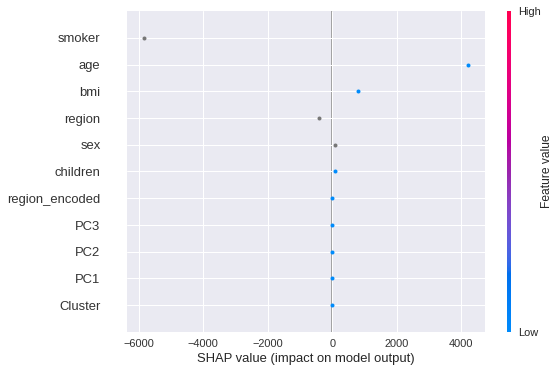

In [132]:
data_for_prediction = X_test_3.iloc[42:43,]
make_shap_summary_plot(data_for_prediction)

**SHAP Dependence Contribution Plots**
- Partial dependence plots show how single feature affects predictions;
- What is the distribution of these effects when broken down by row?
- Focus on shape first (trend), then colour (does trend maintain for each colour?).

In [137]:
def make_shap_dependence_contribution_plot(data_for_prediction, feature_to_inspect, feature_to_hue=None):
    explainer = shap.KernelExplainer(model_predict, data=X_test_3)
    shap_values = explainer.shap_values(data_for_prediction)
    # Choose feature to inspect
    feature_to_inspect = feature_to_inspect
    # Choose feature to hue
    feature_to_hue = feature_to_hue # If None, will choose something interesting
    # Make plot
    shap.dependence_plot(feature_to_inspect, shap_values, data_for_prediction, interaction_index=feature_to_hue)

Using 268 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


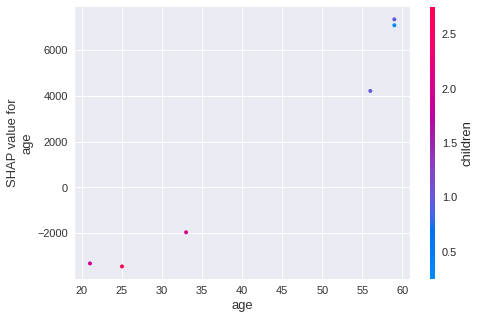

In [138]:
data_for_prediction = X_test_3.iloc[42:48,]
make_shap_dependence_contribution_plot(data_for_prediction, 'age', 'children')

### LIME

In [ ]:
# pip install lime

In [ ]:
# import lime
# import lime.lime_tabular

### pyBreakDown

## Persisting Final Model

Now using best model with tuned parameters, train final model with Train + Valid + Test data. **NO MORE TUNING.**

In [145]:
# Use all available data
X_final = pd.concat([X, X_test])
y_final = pd.concat([y, y_test])

# Create features in the same way
X_final_3 = create_features(X_final, y_final,
                            numerical_cols=numerical_cols, categorical_cols=['region'])

# Create final model
rf_final = train_model(X_final_3, y_final,
                       model=RandomForestRegressor(**rf_best_params, random_state=42))

For a non- Keras model:

In [146]:
import dill

# Save/dump model to disk
with open('rf_final.dill', 'wb') as f:
    dill.dump(rf_final, f)

In [147]:
# Read saved model
with open('rf_final.dill', 'rb') as f:
    saved_model = dill.load(f)

In [148]:
saved_model

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True)),
                                                                  ('imputer',
                                                                   KNNImputer(add_indicator=False,
                                                                              copy=True,

# Step 8: Present Your Solution

1. Document what you have done.
2. Create a nice presentation.
  - Make sure you highlight the big picture first.
3. Explain why your solution achieves the business objective.
4. Don’t forget to present interesting points you noticed along the way.
  - Describe what worked and what did not.
  - List your assumptions and your system’s limitations.
5. Ensure your key findings are communicated through beautiful visualizations or
easy-to-remember statements (e.g., “the median income is the number-one predictor of housing prices”).

# Step 9: Launch and Monitor

1. Get your solution ready for production (plug into production data inputs, write unit tests, etc.).
2. Write monitoring code to check your system’s live performance at regular intervals and trigger alerts when it drops.
  - Beware of slow degradation: models tend to “rot” as data evolves.
  - Measuring performance may require a human pipeline (e.g., via a crowdsourc‐
ing service).
  - Also monitor your inputs’ quality (e.g., a malfunctioning sensor sending random values, or another team’s output becoming stale). This is particularly
important for online learning systems.
3. Retrain your models on a regular basis on fresh data (automate as much as
possible).